In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Set seed for reproducibility
np.random.seed(42)

# Load and preprocess data
train_df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')
train_df['label'] = train_df['label'].astype(str)
train_df['path'] = train_df['image_id'].apply(lambda x: '/kaggle/input/cassava-leaf-disease-classification/train_images/' + x)
train_df = train_df[['path', 'label']]
train_df.head()


,path,label
0,/kaggle/input/cassava-leaf-disease-classificat...,0
1,/kaggle/input/cassava-leaf-disease-classificat...,3
2,/kaggle/input/cassava-leaf-disease-classificat...,1
3,/kaggle/input/cassava-leaf-disease-classificat...,1
4,/kaggle/input/cassava-leaf-disease-classificat...,3


In [3]:
train_df.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [4]:
train_df.sample(frac=1).reset_index(drop=True)

,path,label
0,/kaggle/input/cassava-leaf-disease-classificat...,4
1,/kaggle/input/cassava-leaf-disease-classificat...,3
2,/kaggle/input/cassava-leaf-disease-classificat...,3
3,/kaggle/input/cassava-leaf-disease-classificat...,2
4,/kaggle/input/cassava-leaf-disease-classificat...,2
...,...,...
21392,/kaggle/input/cassava-leaf-disease-classificat...,3
21393,/kaggle/input/cassava-leaf-disease-classificat...,4
21394,/kaggle/input/cassava-leaf-disease-classificat...,2
21395,/kaggle/input/cassava-leaf-disease-classificat...,3


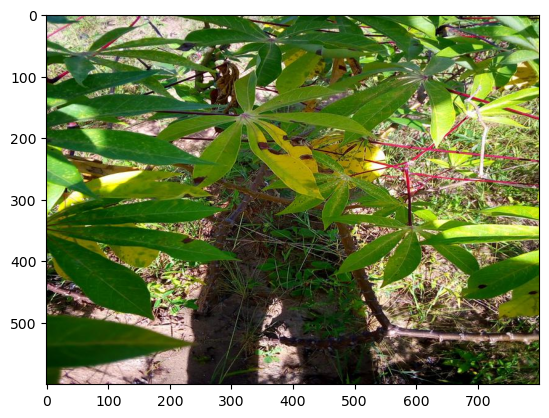

In [5]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('../input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

## Data Prepraration and Training

In [6]:
from typing import Any, Dict, Optional, List

import torch
import pytorch_lightning as pl
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import cv2
import os
import pandas as pd
from sklearn.model_selection import StratifiedKFold

import timm
import json

import torch
import torchvision
import pytorch_lightning as pl
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import io
from PIL import Image

from torchmetrics import F1Score, Precision, Recall, ConfusionMatrix, MaxMetric, MeanMetric
from torchmetrics.classification.accuracy import Accuracy

In [7]:
from typing import Any, Dict, Optional, List

import torch
import pytorch_lightning as pl
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import cv2
import os
import pandas as pd
from sklearn.model_selection import StratifiedKFold



class CassavaDataset(Dataset):
    def __init__(self, df:pd.DataFrame, imfolder:str, train:bool=True, transforms=None):
        super().__init__()
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_id'])
        x = cv2.imread(im_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            x = self.transforms(x)

            
        if self.train:
            y = self.df.iloc[index]['label']
            return x, y
        else:
            return x
    
    def __len__(self):
        return len(self.df)
            

class ClassificationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        images_dir = "",
        train_csv:str="./train.csv",
        batch_size: int = 256,
        num_workers: int = 0,
        pin_memory: bool = False,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)
        self.train_csv = train_csv
        self.images_dir = images_dir
        ######################
        # data transformations
        ######################
        # References: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html
        

        self.transforms1 = T.RandomApply(
            [
                T.RandomRotation(degrees=(0, 70)),
                T.RandomHorizontalFlip(p=0.5),
                T.ColorJitter(brightness=(0.1, 0.6), contrast=1, saturation=0, hue=0.3),
                T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                T.RandomHorizontalFlip(p=0.3),
            ], 
            p=0.3
        )
        self.train_transforms = T.Compose([
                T.ToPILImage(),
                self.transforms1,
                T.Resize((224, 224)),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.valid_transforms = T.Compose([
                T.ToPILImage(),
                T.Resize((224, 224)),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.train_dataset: Optional[Dataset] = None
        self.valid_dataset: Optional[Dataset] = None


    def prepare_data(self):
        """Download data if needed.
        Do not use it to assign state (self.x = y).
        """
        df = pd.read_csv(self.train_csv)
        df['kfold'] = -1
        df = df.sample(frac=1).reset_index(drop=True)
        stratify = StratifiedKFold(n_splits=5)
        for i, (t_idx, v_idx) in enumerate(stratify.split(X=df['image_id'].values, y=df['label'].values)):
            df.loc[v_idx, "kfold"] = i
        
        df.to_csv("train_folds.csv", index=False)
            
        
    def setup(self, stage: Optional[str] = None):
        """Load data. 
        This method is called by lightning with both `trainer.fit()` and `trainer.test()`, so be
        careful not to execute things like random split twice!
        """
        self.prepare_data()
        dfx = pd.read_csv("train_folds.csv")
        train_data = dfx.loc[dfx['kfold'] != 1]
        val_data = dfx.loc[dfx['kfold'] == 1]
        
        self.train_dataset = CassavaDataset(
            train_data,
            self.images_dir,
            train=True,
            transforms=self.train_transforms
        )

        self.valid_dataset = CassavaDataset(
            val_data,
            self.images_dir,
            train=True,
            transforms=self.valid_transforms
        )
        
        
    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.valid_dataset,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    
    def teardown(self, stage: Optional[str] = None):
        """Clean up after fit or test."""
        pass

    def state_dict(self):
        """Extra things to save to checkpoint."""
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]):
        """Things to do when loading checkpoint."""
        pass



### Define Model

In [8]:
from typing import Any, Dict, Optional, List
import timm
import json

import torch
import torchvision
import pytorch_lightning as pl
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import io
from PIL import Image

from torchmetrics import F1Score, Precision, Recall, ConfusionMatrix, MaxMetric, MeanMetric
from torchmetrics.classification.accuracy import Accuracy


class IntHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        text = plt.matplotlib.text.Text(x0, y0, str(orig_handle))
        handlebox.add_artist(text)
        return text

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CassavaLite(pl.LightningModule):
    def __init__(self, num_classes=10, model_name='resnet18', optim_name="SGD", lr=0.05):
        super().__init__()

        self.num_classes = num_classes
        self.save_hyperparameters()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

        self.lr = lr
        # configure optimizer
        if optim_name == "ADAM":
            self.optim_name = torch.optim.Adam
        if optim_name == "SGD":
            self.optim_name = torch.optim.SGD
        if optim_name == "RMS":
            self.optim_name = torch.optim.RMSprop

        # loss function
        self.criterion = torch.nn.CrossEntropyLoss()
        
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # metric objects for calculating and averaging accuracy across batches
        self.train_acc = Accuracy(task='multiclass', num_classes=self.num_classes)
        self.val_acc = Accuracy(task='multiclass', num_classes=self.num_classes)
        self.test_acc = Accuracy(task='multiclass', num_classes=self.num_classes)

        # some other metrics to be logged
        self.f1_score = F1Score(task="multiclass", num_classes=self.num_classes)
        self.precision_score = Precision(task="multiclass", average='macro', num_classes=self.num_classes)
        self.recall_score = Recall(task="multiclass", average='macro', num_classes=self.num_classes)

    def forward(self, x):
        return self.model(x)
    
    
    def step(self, batch: Any):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    def training_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.step(batch)

        # update and log metrics
        self.train_loss(loss)
        self.train_acc(preds, targets)
        self.log("train/loss", self.train_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train/acc", self.train_acc, on_step=True, on_epoch=True, prog_bar=True)

        # we can return here dict with any tensors
        # and then read it in some callback or in `training_epoch_end()` below
        # remember to always return loss from `training_step()` or backpropagation will fail!
        return {"loss": loss, "preds": preds, "targets": targets}

    def training_epoch_end(self, outputs: List[Any]):
        # `outputs` is a list of dicts returned from `training_step()`
        pass

    def validation_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.step(batch)

        # update and log metrics
        self.val_loss(loss)
        self.val_acc(preds, targets)
        self.f1_score(preds, targets)
        self.precision_score(preds, targets)
        self.recall_score(preds, targets)
        self.log("val/loss", self.val_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val/acc", self.val_acc, on_step=True, on_epoch=True, prog_bar=False)
        self.log("val/f1", self.val_acc, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val/precision", self.precision_score, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val/recall", self.recall_score, on_step=False, on_epoch=True, prog_bar=False)
        return {"loss": loss, "preds": preds, "targets": targets}

    def validation_epoch_end(self, outs: List[Any]):
        tb = self.logger.experiment  # noqa

        outputs = torch.cat([tmp['preds'] for tmp in outs])
        labels = torch.cat([tmp['targets'] for tmp in outs])

        confusion = ConfusionMatrix(task="multiclass", num_classes=self.num_classes).to(device)
        confusion(outputs, labels)
        computed_confusion = confusion.compute().detach().cpu().numpy().astype(int)

        # confusion matrix
        df_cm = pd.DataFrame(
            computed_confusion,
            index=[0, 1, 2, 3, 4],
            columns= ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)',
             'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']
        )

        fig, ax = plt.subplots(figsize=(10, 5))
        fig.subplots_adjust(left=0.05, right=.65)
        sn.set(font_scale=1.2)
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', ax=ax)
        ax.legend(
            [0, 1, 2, 3, 4],
            ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)',
             'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy'],
            handler_map={int: IntHandler()},
            loc='upper left',
            bbox_to_anchor=(1.2, 1)
        )
        buf = io.BytesIO()

        plt.savefig(buf, format='jpeg', bbox_inches='tight')
        buf.seek(0)
        im = Image.open(buf)
        im = torchvision.transforms.ToTensor()(im)
        tb.add_image("val_confusion_matrix", im, global_step=self.current_epoch)

    def test_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.step(batch)

        # update and log metrics
        self.test_loss(loss)
        self.test_acc(preds, targets)
        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/acc", self.test_acc, on_step=False, on_epoch=True, prog_bar=True)

        return {"loss": loss, "preds": preds, "targets": targets}

    def test_epoch_end(self, outputs: List[Any]):
        pass

    def configure_optimizers(self):
        optimizer = self.optim_name(
            self.parameters(),
            lr=self.lr,
        )
        sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size  = 10 , gamma = 0.5)
        return {
            "optimizer":optimizer,
            "lr_scheduler" : {
                "scheduler" : sch,
                "monitor" : "train/loss",
                
            }
          }

### Prepare Training

In [9]:
# Hyperparameters

model_name = "regnetz_c16"
optimizer_name = "ADAM"
learning_rate = 0.000012
batch_size = 64

In [10]:
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision.datasets import ImageFolder
from pathlib import Path


def train(model, datamodule):
    tb_logger = pl_loggers.TensorBoardLogger(save_dir="output")
    early_stop_callback = EarlyStopping(monitor="val/acc", min_delta=0.00, patience=3, verbose=False, mode="max")
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="auto",
        callbacks=[early_stop_callback],
        logger=[tb_logger]
    )
    hyperparameters = dict(model_name=model_name, optimizer_name=optimizer_name, learning_rate=learning_rate)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, datamodule)
    
    return trainer

def save_scripted_model(model):
    script = model.to_torchscript()

    # save for use in production environment
    torch.jit.save(script,"model.scripted.pt")
    
    
def save_model(model):
    torch.save(model.state_dict(), "model.pt")


def save_last_ckpt(trainer):
    trainer.save_checkpoint("last.ckpt")


In [11]:
images_dir = "/kaggle/input/cassava-leaf-disease-classification/train_images"
train_csv = "/kaggle/input/cassava-leaf-disease-classification/train.csv"
num_classes = 5

:: Datamodule setup completed ..


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-attn-weights/regnetz_c_rab2_256-a54bf36a.pth" to /root/.cache/torch/hub/checkpoints/regnetz_c_rab2_256-a54bf36a.pth


:: Training ...


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

:: Saving Model Ckpt
:: Saving  Model


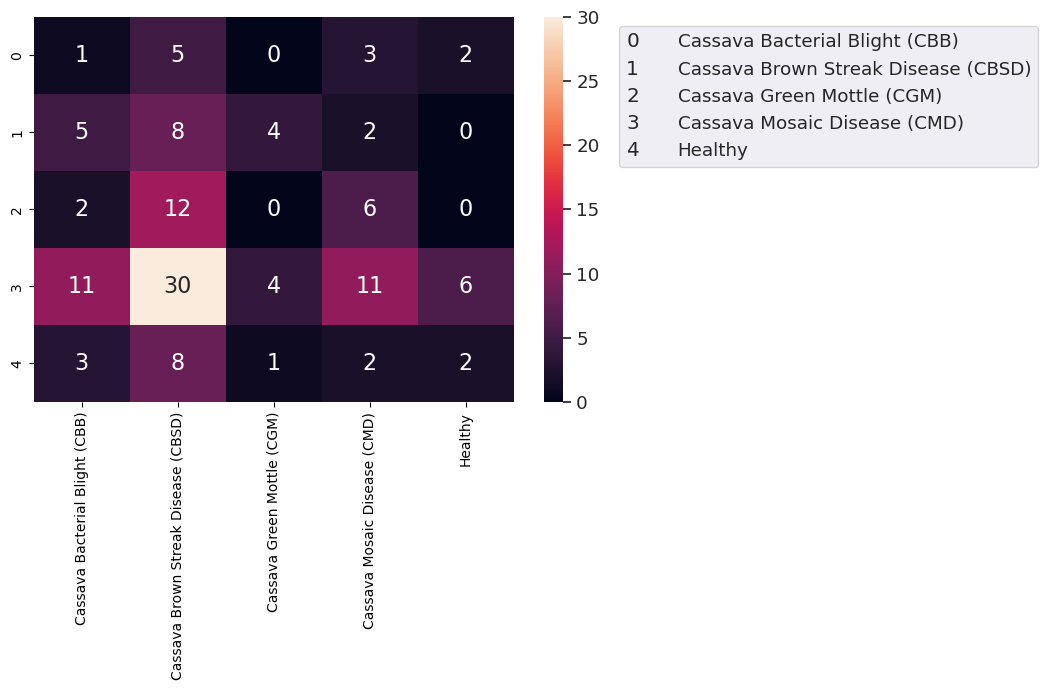

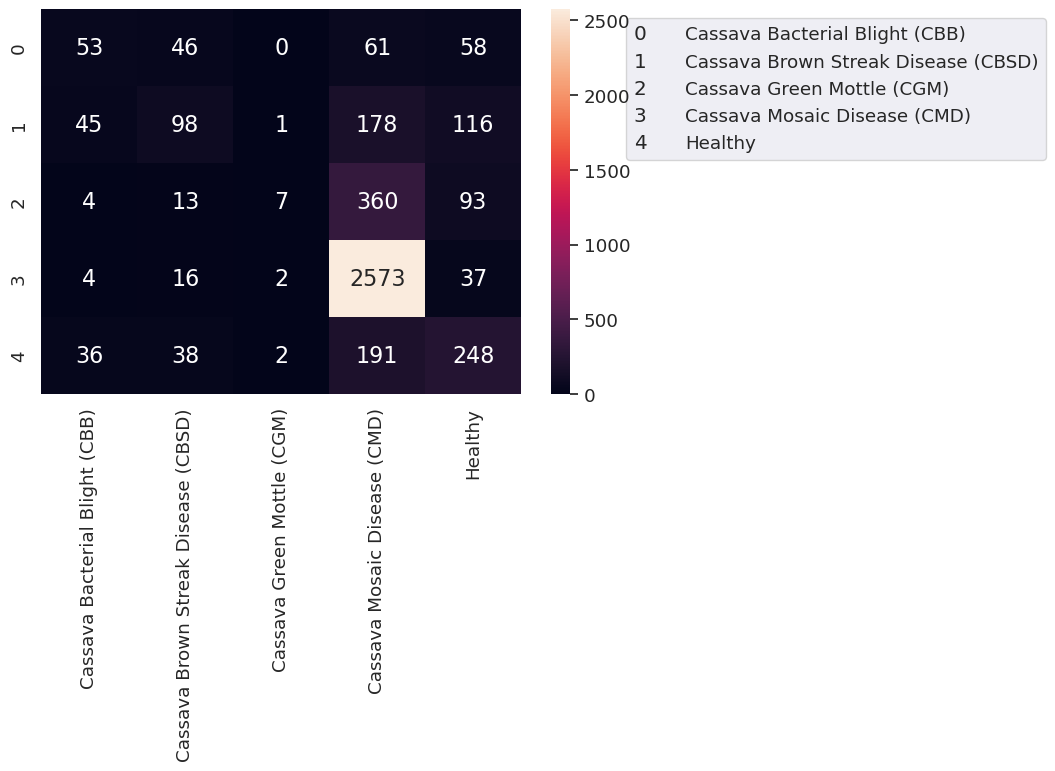

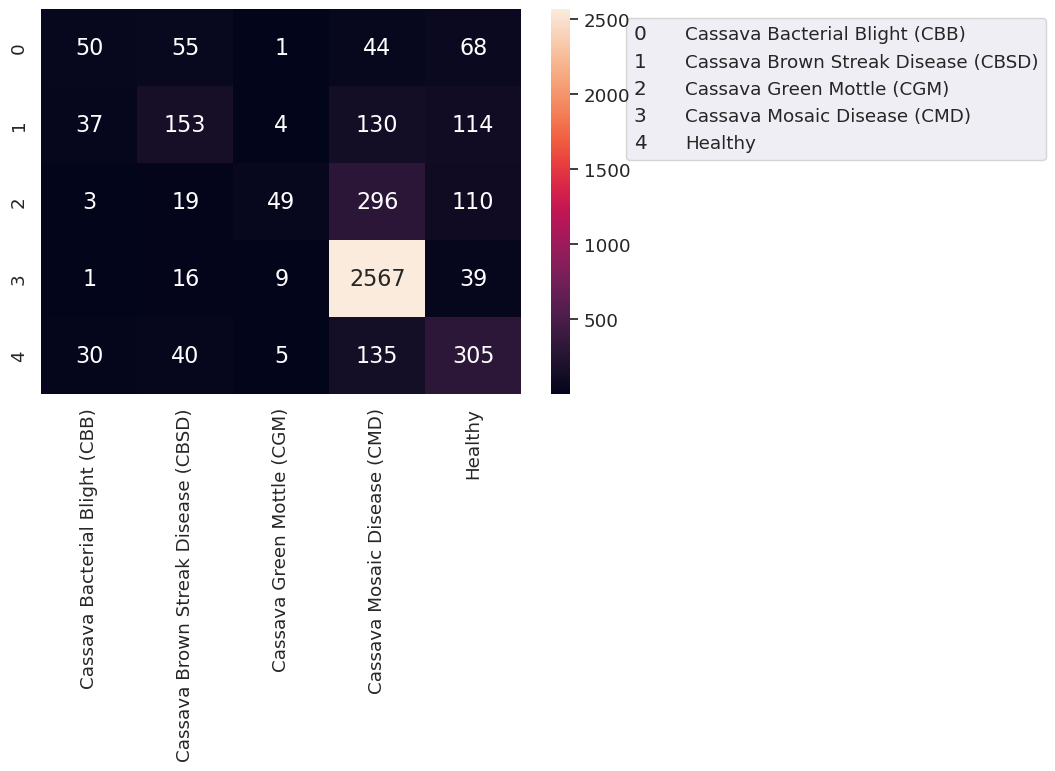

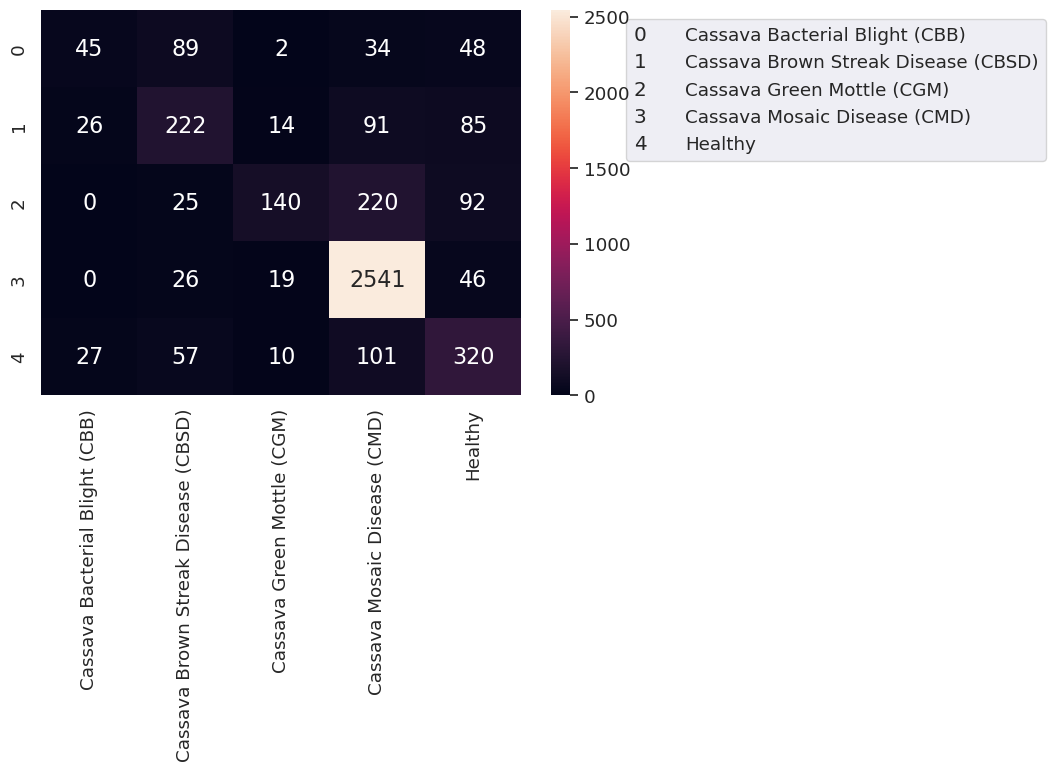

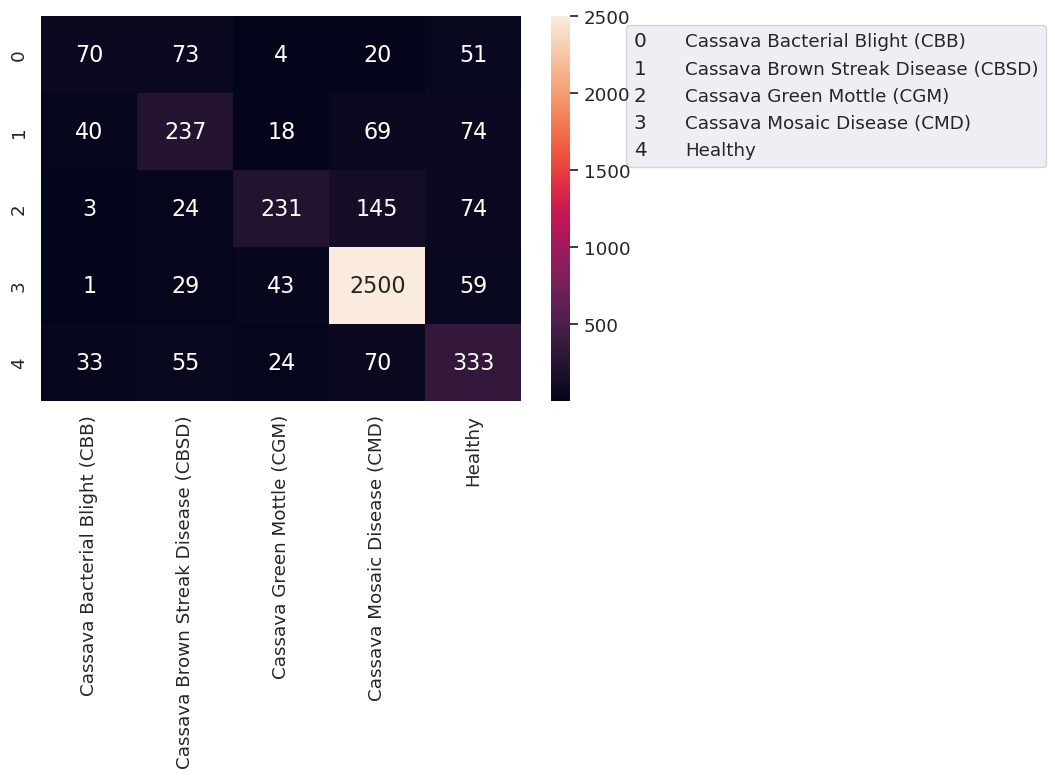

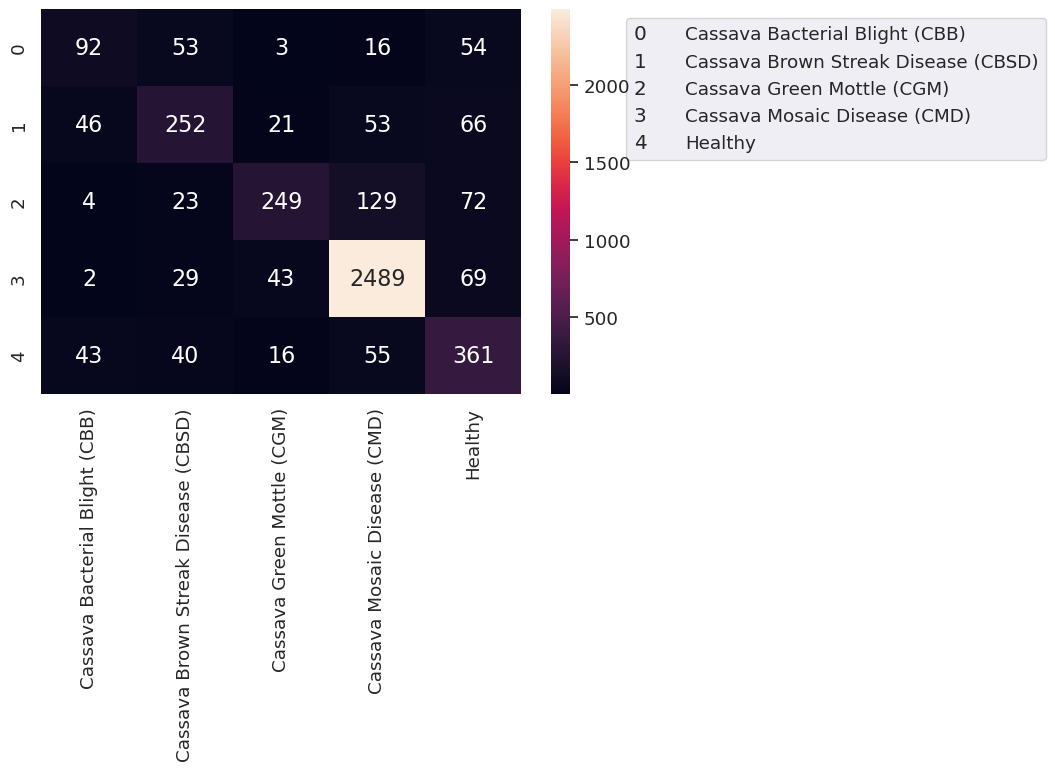

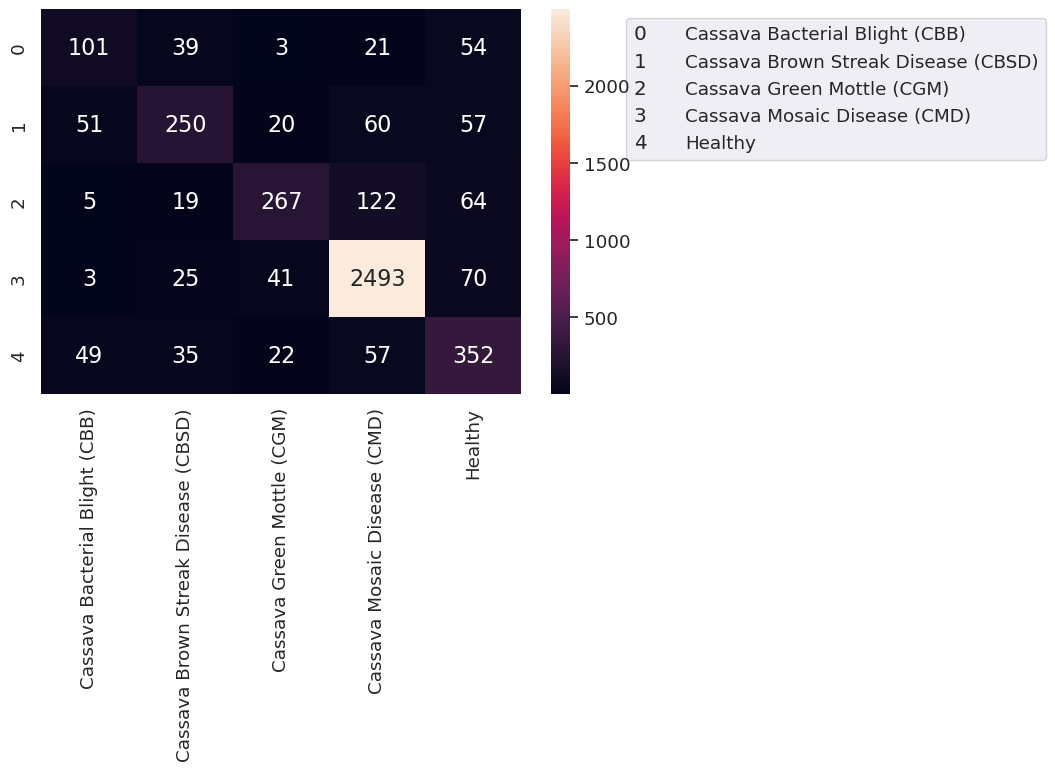

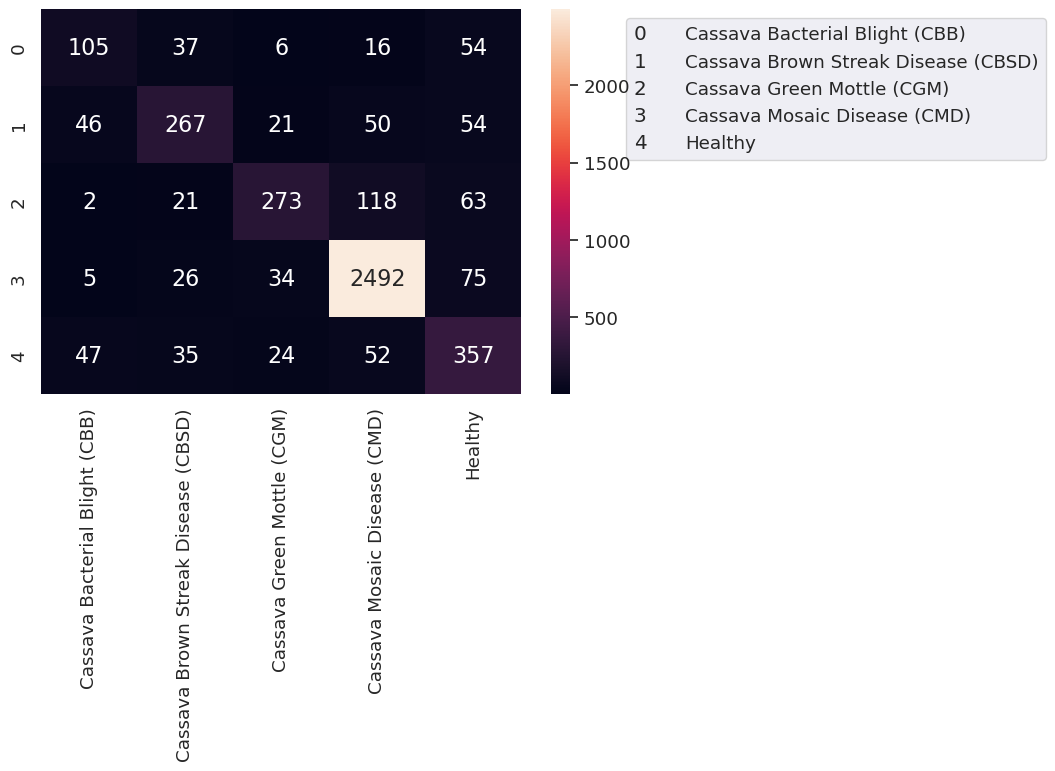

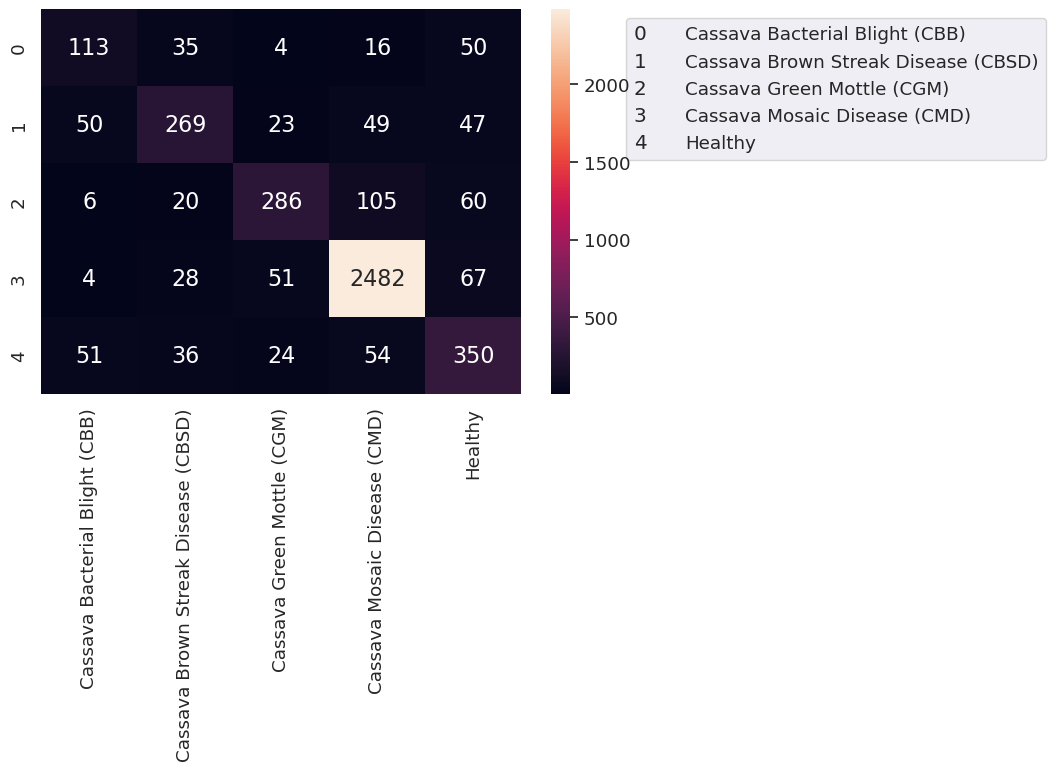

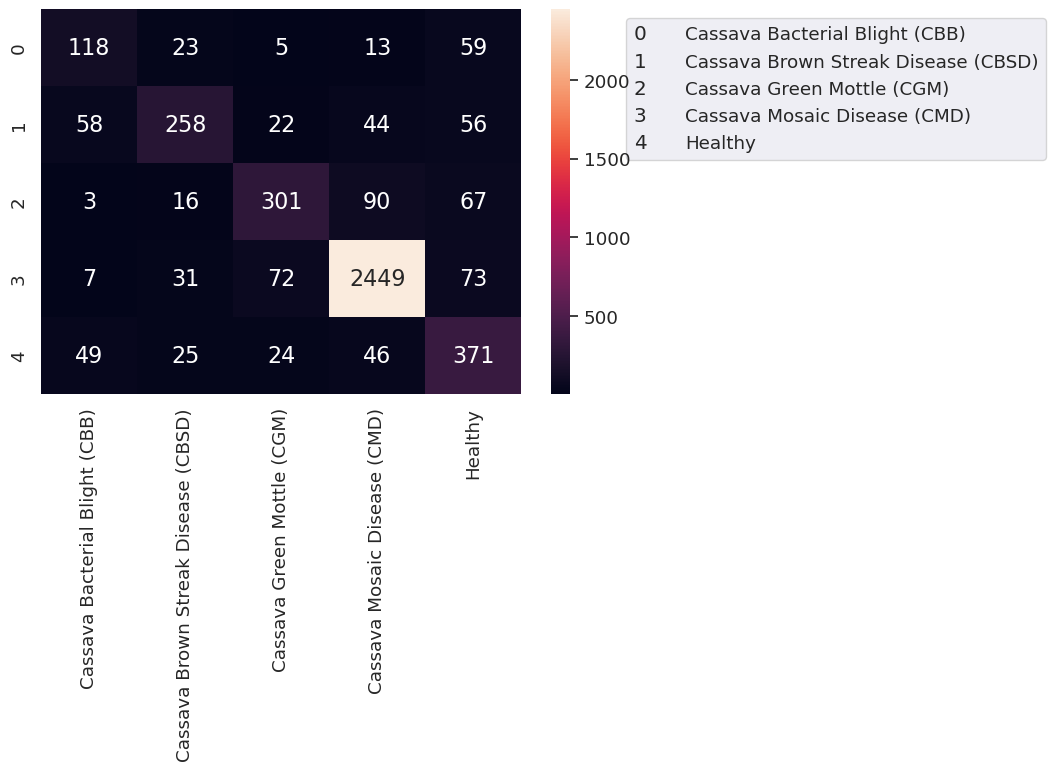

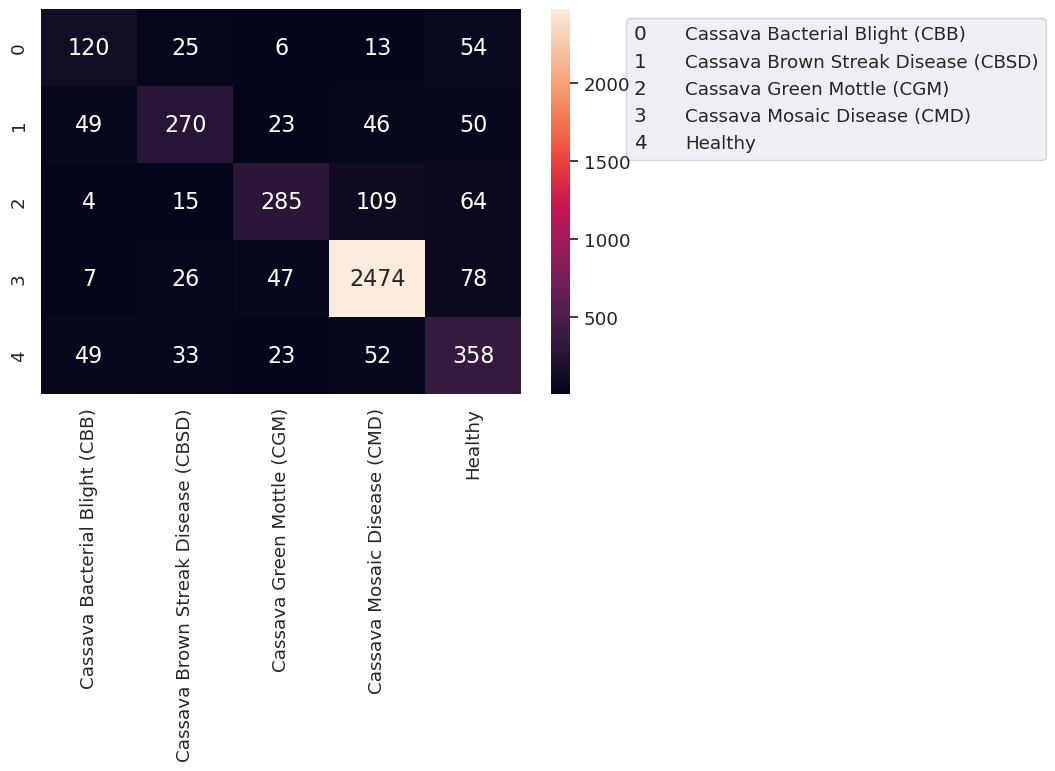

In [12]:
# Reading dataset    
    
datamodule = ClassificationDataModule(images_dir=images_dir, train_csv=train_csv,
                                               batch_size=batch_size,num_workers=2)
datamodule.setup()
    
print(":: Datamodule setup completed ..")
model = CassavaLite(num_classes=num_classes, model_name=model_name, optim_name=optimizer_name,
                      lr=learning_rate)
        
print(":: Training ...")
trainer = train(model, datamodule)
    
print(":: Saving Model Ckpt")
save_last_ckpt(trainer)
    
# set to evaluation model before scripting
print(":: Saving  Model")
save_scripted_model(model)
save_model(model)

In [13]:
!ls /kaggle/working

__notebook__.ipynb  model.pt	       output
last.ckpt	    model.scripted.pt  train_folds.csv
